In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import spectrogram
from pathlib import Path

from pyaw import utils
from pyaw.swarm import rotate_vector_by_quaternion, calculate_rotated_vectors

%load_ext watermark
%watermark -i -v -p matplotlib,numpy,pandas,scipy

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.27.0

matplotlib: 3.8.0
numpy     : 1.25.2
pandas    : 2.2.2
scipy     : 1.13.1



In [2]:
fps = [
    r"\\Diskstation1\file_three\aw\swarm\vires\SW_OPER_MAGA_HR_1B\SW_OPER_MAGA_HR_1B_12728_20160301T012924_20160301T030258.pkl",
    r"\\Diskstation1\file_three\aw\swarm\vires\AHY9U3~9\SW_OPER_MAGA_HR_1B\aux_SW_OPER_MAGA_HR_1B_12728_20160301T012924_20160301T030258.pkl",
    r"\\Diskstation1\file_three\aw\swarm\vires\IGRF\SW_OPER_MAGA_HR_1B\IGRF_SW_OPER_MAGA_HR_1B_12728_20160301T012924_20160301T030258.pkl",
    r"\\Diskstation1\file_three\aw\swarm\vires\SW_EXPT_EFIA_TCT16\SW_EXPT_EFIA_TCT16_12728_20160301T012924_20160301T030258.pkl"
]

In [3]:
df_b = pd.read_pickle(fps[0])
# df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

In [4]:
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius', 'q_NEC_CRF']]
# df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]

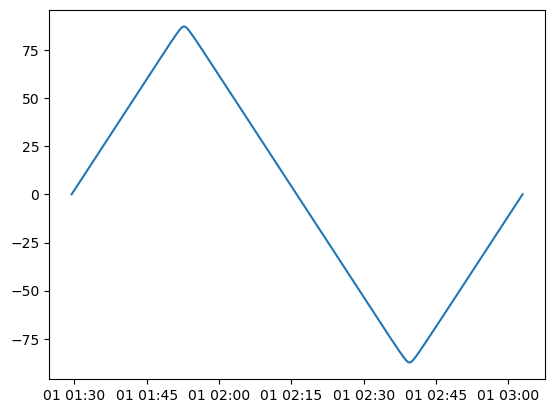

In [5]:
plt.figure()
plt.plot(df_b_clip.index.values, df_b_clip['Latitude'].values)
plt.show()

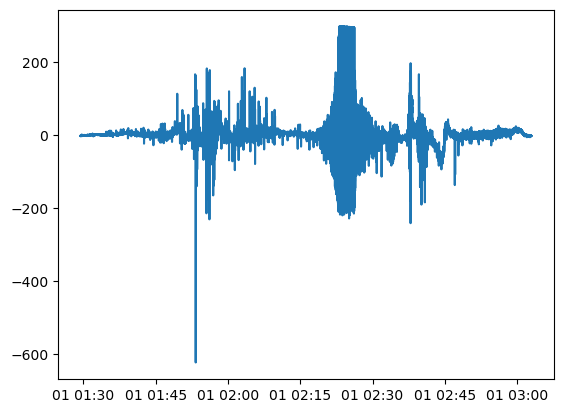

In [6]:
ehx = df_e_clip['Ehx'].values

plt.plot(df_e_clip.index.values, ehx)
plt.show()  # todo:: add lat... labels.

(array([16861.0625    , 16861.07291667, 16861.08333333, 16861.09375   ,
        16861.10416667, 16861.11458333, 16861.125     ]),
 [Text(16861.0625, 0, '01 01:30'),
  Text(16861.072916666668, 0, '01 01:45'),
  Text(16861.083333333332, 0, '01 02:00'),
  Text(16861.09375, 0, '01 02:15'),
  Text(16861.104166666668, 0, '01 02:30'),
  Text(16861.114583333332, 0, '01 02:45'),
  Text(16861.125, 0, '01 03:00')])

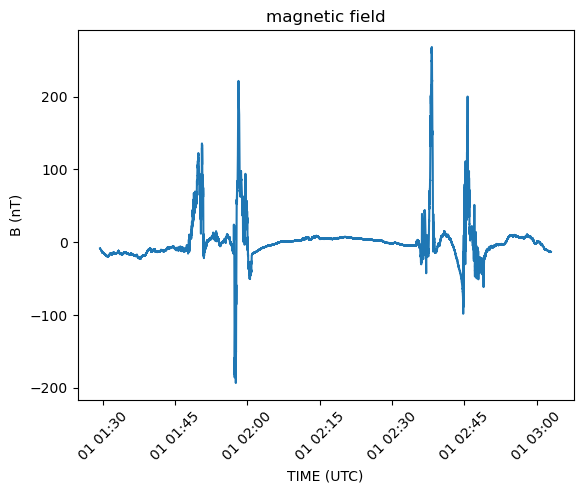

In [7]:
b_sc,b_igrf_sc = calculate_rotated_vectors(df_b_clip['B_NEC'].values, df_b_IGRF_clip['B_NEC_IGRF'].values, df_b_clip['q_NEC_CRF'].values)

by1 = b_sc[:, 1] - b_igrf_sc[:, 1]

plt.plot(df_b_clip.index.values, by1)
plt.title("magnetic field")
plt.xlabel("TIME (UTC)")
plt.ylabel("B (nT)")
plt.xticks(rotation=45)

In [8]:
by1

array([ -8.54805451,  -8.58490815,  -8.62414156, ..., -13.51453158,
       -13.48961111, -13.48081418])

In [8]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

by1 = utils.align_high2low(by1, datetimes_b, datetimes_e)

In [9]:
fs = 16
window = 'hann'
stft_window_seconds = 4
nperseg = int(stft_window_seconds * fs)
noverlap = nperseg // 2

freqs, ts, Sxx_e = spectrogram(ehx, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')
_, _, Sxx_b = spectrogram(by1, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64 = datetimes_e[0] + [np.timedelta64(int(_), 's') for _ in ts]

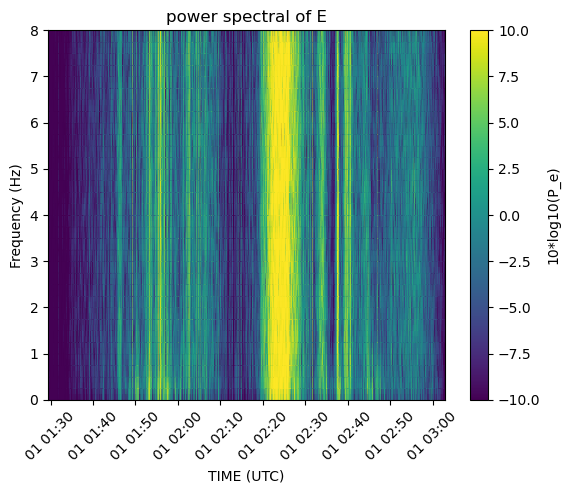

In [10]:
Sxx_e_m = np.abs(Sxx_e)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(Sxx_e_m), shading='gouraud', vmin=-10, vmax=10)
plt.title("power spectral of E")
plt.xlabel("TIME (UTC)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='10*log10(P_e)')
plt.xticks(rotation=45)
plt.show()

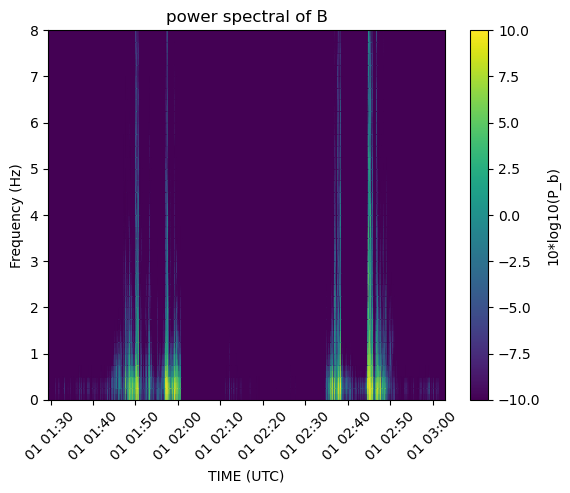

In [11]:
Sxx_b_m = np.abs(Sxx_b)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(Sxx_b_m), shading='gouraud', vmin=-10, vmax=10)
plt.title("power spectral of B")
plt.xlabel("TIME (UTC)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='10*log10(P_b)')
plt.ylim([0, 8])
plt.xticks(rotation=45)
plt.show()

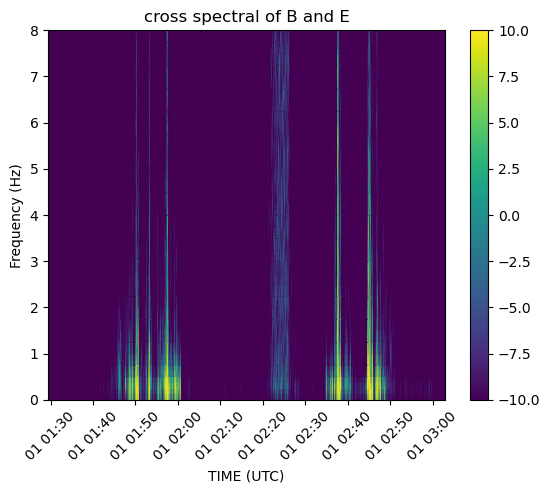

In [12]:
cpsd = Sxx_e * np.conj(Sxx_b)

cpsd_m = np.abs(cpsd)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(cpsd_m), shading='gouraud', vmin=-10, vmax=10)
plt.title("cross spectral of B and E")
plt.xlabel("TIME (UTC)")
plt.ylabel("Frequency (Hz)")
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [29]:
st_dy = np.datetime64('2016-03-01T01:50:00')
et_dy = np.datetime64('2016-03-01T01:51:00')
t_mask = (datetimes_e >= st_dy) & (datetimes_e <= et_dy)
datetimes_dy = datetimes_e[t_mask]
ehx_dy = ehx[t_mask]
by1_dy = by1[t_mask]

In [30]:
ehx_dy_fft = utils.FFT(ehx_dy, fs)
by1_dy_fft = utils.FFT(by1_dy, fs)

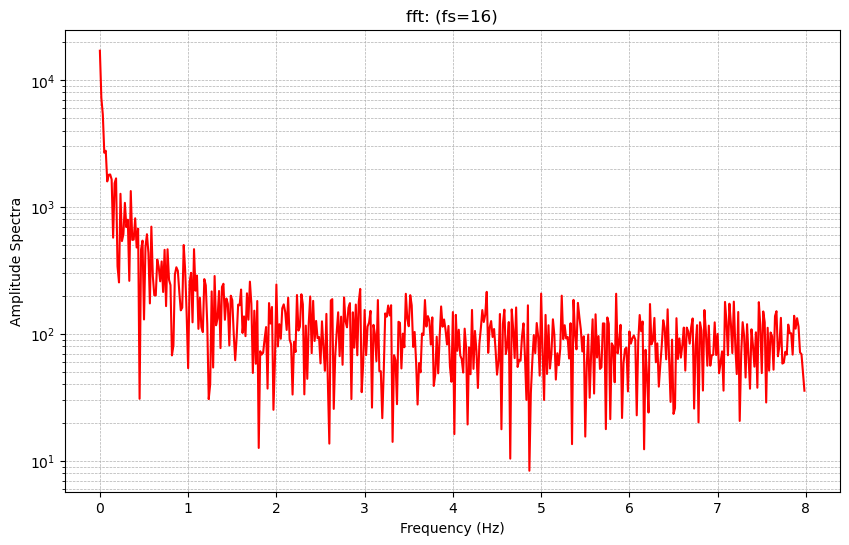

In [31]:
ehx_dy_fft.plot_fft()
plt.show()

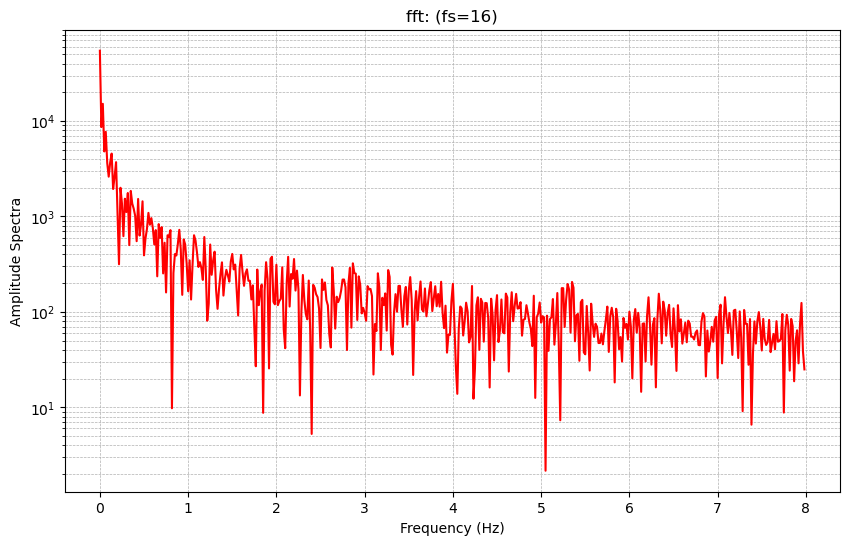

In [32]:
by1_dy_fft.plot_fft()
plt.show()

In [33]:
freqs_dy, amp_e_dy, _ = ehx_dy_fft.get_fft()
_, amp_b_dy, _ = by1_dy_fft.get_fft()

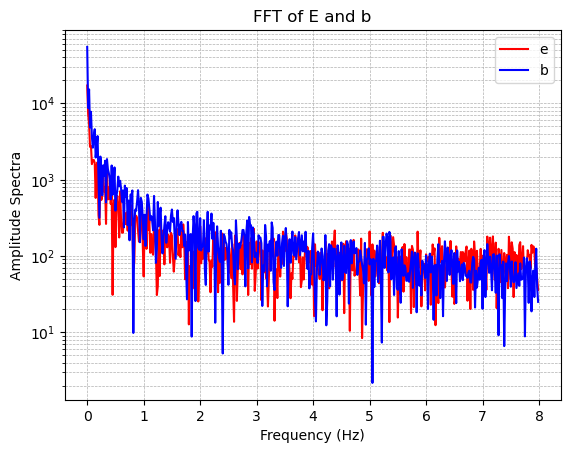

In [34]:
plt.plot(freqs_dy, amp_e_dy, color='red', label='e')
plt.plot(freqs_dy, amp_b_dy, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.title("FFT of E and b")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [35]:
eb_ratio_fft_dy = amp_e_dy / amp_b_dy
eb_ratio_fft_dy = eb_ratio_fft_dy * 1e-3 * 1e9  # 此处考虑了单位换算

In [36]:
from pyaw.paras import mu0

Sigma_P_dy = 3.0
Sigma_P_sta = 0.5

va_dy = 1.4e6
va_sta = 1.3e6

boundary_l_dy = 1 / (mu0 * Sigma_P_dy)
boundary_h_dy = mu0 * va_dy ** 2 * Sigma_P_dy

boundary_l_sta = 1 / (mu0 * Sigma_P_sta)
boundary_h_sta = mu0 * va_sta ** 2 * Sigma_P_sta

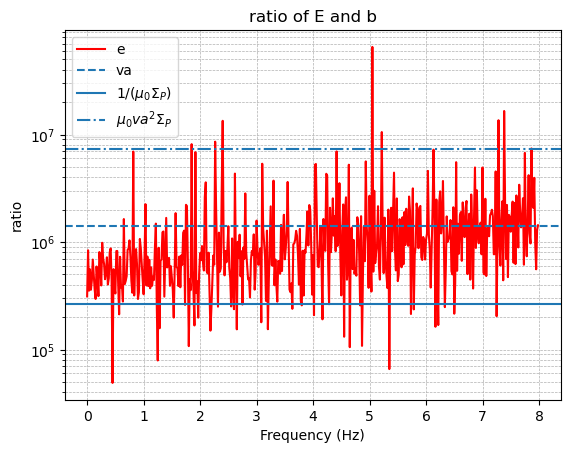

In [37]:
plt.plot(freqs_dy, eb_ratio_fft_dy, color='red', label='e')
plt.axhline(va_dy, linestyle='--', label='va')
plt.axhline(boundary_l_dy, linestyle='-', label=r'$1/(\mu_0 \Sigma_P)$')
plt.axhline(boundary_h_dy, linestyle='-.', label=r'$\mu_0 va^2 \Sigma_P$')
plt.xscale('linear')
plt.yscale('log')
plt.legend()
plt.title("ratio of E and b")
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()  # ratio histogram2d 可以作为补充

In [38]:
freqs_dy, ts_dy, Sxx_e_dy = spectrogram(ehx_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                        mode='complex')
_, _, Sxx_b_dy = spectrogram(by1_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64_dy = datetimes_dy[0] + [np.timedelta64(int(_), 's') for _ in ts_dy]

cpsd_dy = Sxx_e_dy * np.conj(Sxx_b_dy)

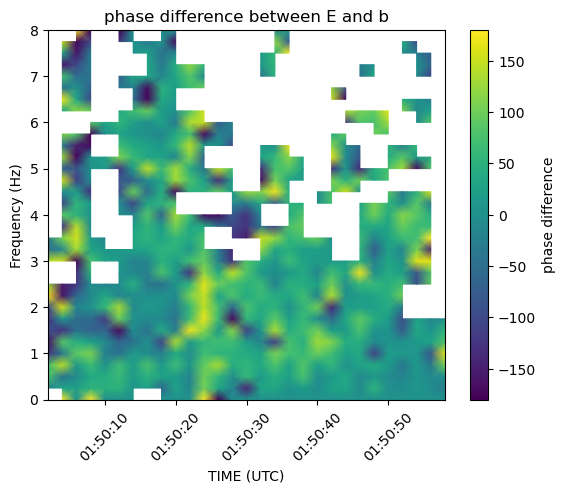

In [39]:
# phase
cpsd_phase_dy = np.degrees(np.angle(cpsd_dy))
cpsd_m_dy = np.abs(cpsd_dy)
cpsd_phase_dy[cpsd_m_dy < 0.03] = np.nan  # 阈值的选择？
plt.pcolormesh(ts_dt64_dy, freqs_dy, cpsd_phase_dy, shading='gouraud')
plt.title("phase difference between E and b")
plt.xlabel("TIME (UTC)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='phase difference')
plt.xticks(rotation=45)
plt.show()

In [40]:
num_bins = 50
phase_bins_dy, phase_histogram2d_dy = utils.get_phase_histogram2d(freqs_dy, cpsd_phase_dy, num_bins=num_bins)

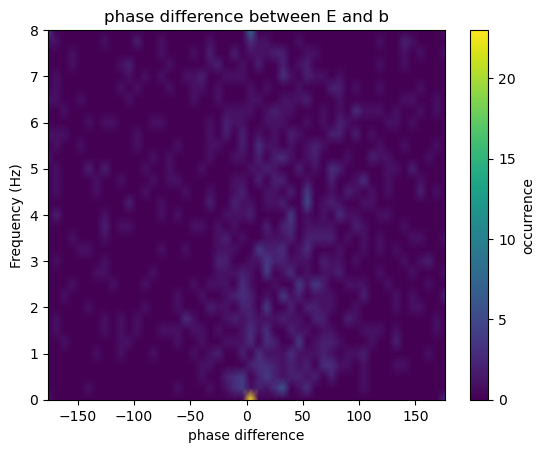

In [41]:
plt.pcolormesh((phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2, freqs_dy, phase_histogram2d_dy, shading='gouraud')
plt.title("phase difference between E and b")
plt.xlabel("phase difference")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='occurrence')
plt.show()

In [42]:
phase_bins_dy_ave = utils.get_phase_histogram_f_ave(phase_bins_dy, phase_histogram2d_dy)

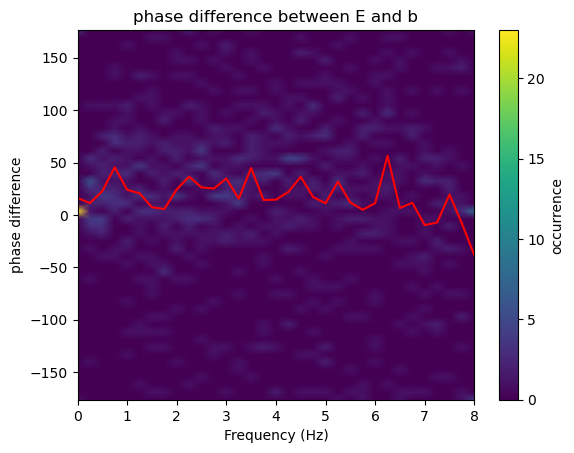

In [43]:
plt.pcolormesh(freqs_dy, (phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2, phase_histogram2d_dy.T, shading='gouraud')
plt.plot(freqs_dy, phase_bins_dy_ave, color='r')
plt.title("phase difference between E and b")
plt.xlabel("Frequency (Hz)")
plt.ylabel("phase difference")
plt.colorbar(label='occurrence')
plt.show()

In [44]:
# static

In [45]:
st_sta = np.datetime64('2016-03-01T01:40:00')
et_sta = np.datetime64('2016-03-01T01:41:00')
t_mask = (datetimes_e >= st_sta) & (datetimes_e <= et_sta)
datetimes_sta = datetimes_e[t_mask]
ehx_sta = ehx[t_mask]
by1_sta = by1[t_mask]

In [46]:
# 当ehx没有处理异常值时，得到的fft和论文区别很大，处理异常之后，2者近似。
ehx_sta_fft = utils.FFT(ehx_sta, fs)
by1_sta_fft = utils.FFT(by1_sta, fs)

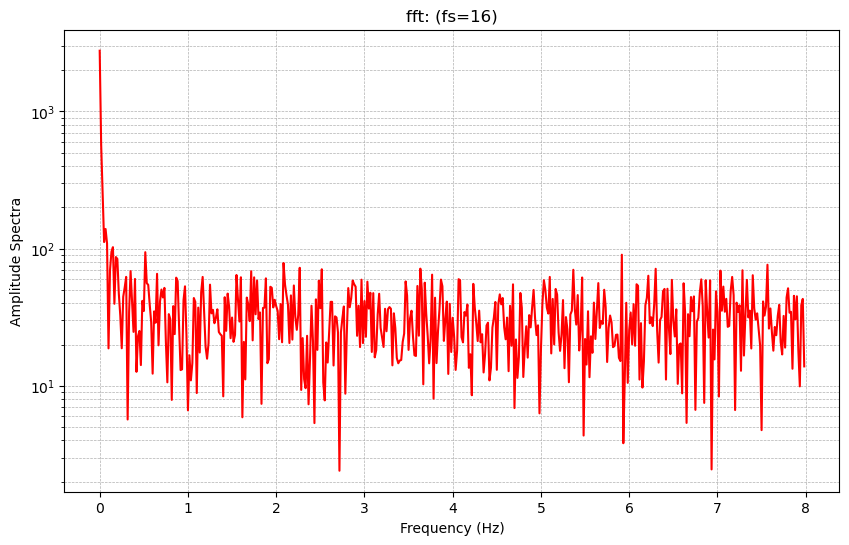

In [47]:
ehx_sta_fft.plot_fft()
plt.show()

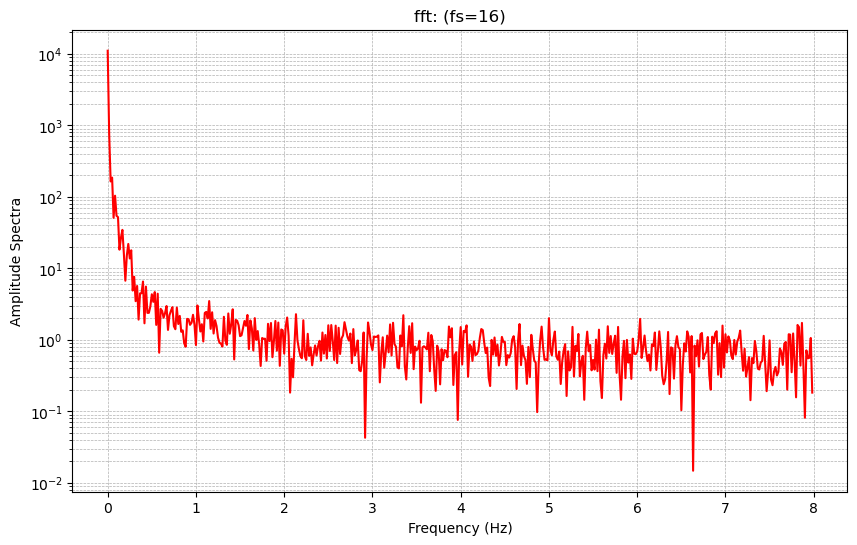

In [48]:
by1_sta_fft.plot_fft()
plt.show()

In [49]:
freqs_sta, amp_e_sta, _ = ehx_sta_fft.get_fft()
_, amp_b_sta, _ = by1_sta_fft.get_fft()

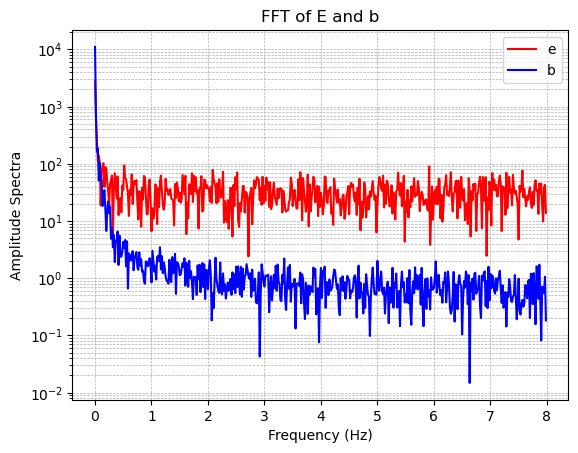

In [50]:
plt.plot(freqs_sta, amp_e_sta, color='red', label='e')
plt.plot(freqs_sta, amp_b_sta, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.title("FFT of E and b")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [51]:
eb_ratio_fft_sta = amp_e_sta / amp_b_sta
eb_ratio_fft_sta = eb_ratio_fft_sta * 1e-3 * 1e9

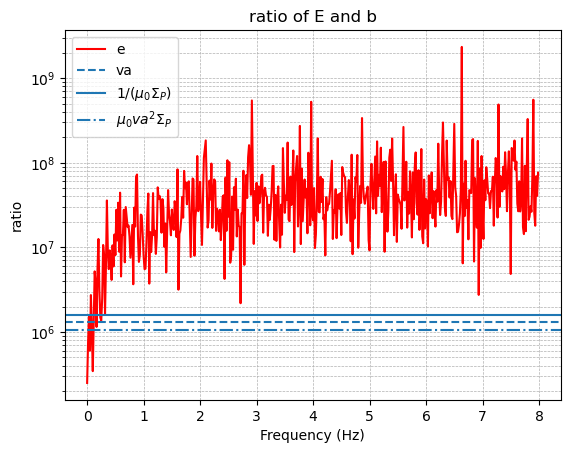

In [52]:
plt.plot(freqs_sta, eb_ratio_fft_sta, color='red', label='e')
plt.axhline(va_sta, linestyle='--', label='va')
plt.axhline(boundary_l_sta, linestyle='-', label=r'$1/(\mu_0 \Sigma_P)$')
plt.axhline(boundary_h_sta, linestyle='-.', label=r'$\mu_0 va^2 \Sigma_P$')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.title("ratio of E and b")
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [53]:
freqs_sta, ts_sta, Sxx_e_sta = spectrogram(ehx_sta, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                           mode='complex')
_, _, Sxx_b_sta = spectrogram(by1_sta, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64_sta = datetimes_sta[0] + [np.timedelta64(int(_), 's') for _ in ts_sta]

cpsd_sta = Sxx_e_sta * np.conj(Sxx_b_sta)

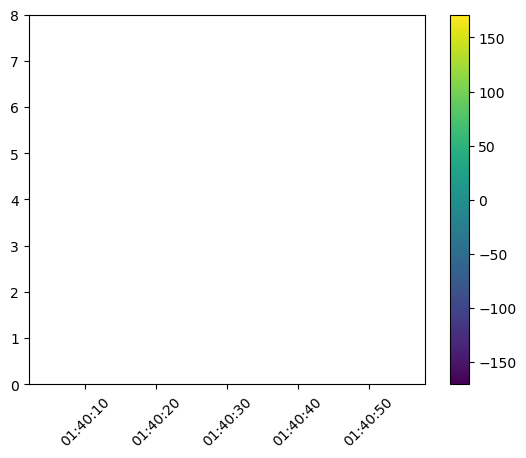

In [54]:
# phase
cpsd_phase_sta = np.degrees(np.angle(cpsd_sta))
cpsd_m_sta = np.abs(cpsd_sta)
cpsd_phase_sta[cpsd_m_sta < 0.03] = np.nan
plt.pcolormesh(ts_dt64_sta, freqs_sta, cpsd_phase_sta, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()